<a href="https://colab.research.google.com/github/RDelg/rl-book/blob/master/chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import OrderedDict

import numpy as np
from numpy import random
from tqdm.notebook import tqdm

In [2]:
class BoundedArraySpec:
    def __init__(self, shape, dtype, minimum, maximum):
        self.shape = shape
        self.dtype = dtype
        self.minimum = minimum
        self.maximum = maximum

In [3]:
class Trajectory:
    class Step:
        def __init__(self, is_final, state, action, reward):
            self.is_final = is_final
            self.state = state
            self.action = action
            self.reward = reward

    def __init__(self):
        self.steps = []

    def add_step(self, is_final, state, action, reward):
        self.steps.append(Trajectory.Step(is_final, state, action, reward))
    
    def __len__(self):
        return len(self.steps)

    def __getitem__(self, index):
        return self.steps[index]
    
    def __repr__(self):
        return str([f't={i}: {step.__dict__}' for i, step in enumerate(self.steps)])

In [4]:
class BlackJack():
    
    _CARDS = OrderedDict({
        '_A': 1,
        '_1': 1,
        '_2': 2,
        '_3': 3,
        '_4': 4,
        '_5': 5,
        '_6': 6,
        '_7': 7,
        '_8': 8,
        '_9': 9,
        '_J': 10,
        '_Q': 10,
        '_K': 10
    })

    def action_spec(self):
        return BoundedArraySpec((1,), np.int32, minimum=[0], maximum=[1])

    def observation_spec(self):
        return BoundedArraySpec([3,], np.int32, minimum=[12, 0, 1], maximum=[21, 1, 11])

    @staticmethod
    def get_card():
        return random.choice(list(BlackJack._CARDS.keys()))
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        # Dealer
        self.dealer_card =  self.get_card()
        self._dealer_usable_ace = self.dealer_card == '_A'
        # Player
        self.player_sum = 0
        self.usable_ace = False
        self.player_sum, self.usable_ace = self.hit(self.player_sum, self.usable_ace)

    @property
    def state(self):
        return (self.player_sum,
                self.usable_ace,
                11 if self._dealer_usable_ace else self._CARDS[self.dealer_card]
        )

    @state.setter
    def state(self, state: tuple):
        self.player_sum = state[0]
        self.usable_ace = state[1]
        self.dealer_card = '_A' if state[2] == 11 else list(self._CARDS.keys())[state[2]]
        self._dealer_usable_ace = self.dealer_card == '_A'

    @staticmethod
    def hit(current_sum: int, usable_ace: bool):
        card = BlackJack.get_card()
        if card == '_A' and current_sum < 11:
            current_sum += 11
            usable_ace = True
        else:
            current_sum += BlackJack._CARDS[card]
            if current_sum > 21 and usable_ace:
                current_sum -= 10
                usable_ace = False
        if current_sum < 12:
            return BlackJack.hit(current_sum, usable_ace)
        else:
            return current_sum, usable_ace
    
    def stick(self):
        dealer_sum = 11 if self._dealer_usable_ace else BlackJack._CARDS[self.dealer_card]
        while dealer_sum < 17:
            dealer_sum, self._dealer_usable_ace =  self.hit(dealer_sum, self._dealer_usable_ace)
        return dealer_sum

    def step(self, action: int):
        """Performs an action and returns the enviroment response.
            Posible action values:
                - 0: Stick
                - 1: Hit
            The return value is a tuple where each position is:
                - [0]: A boolean indicating if the game has ended
                - [1]: The reward obtained
                - [2]: The new state of the game
        """
        if action == 0:
            dealer_sum = self.stick()
            if dealer_sum > 21: # Dealer bust
                return True, 1, self.state
            elif dealer_sum == self.player_sum:
                return True, 0, self.state
            elif dealer_sum < self.player_sum:
                return True, 1, self.state
            else:
                return True, -1, self.state
        elif action == 1:
            self.player_sum, self.usable_ace = self.hit(self.player_sum, self.usable_ace)
            if self.player_sum > 21: # Bust
                return True, -1, self.state
            else:
                return False, 0, self.state
        else:
            raise Exception(f'Invalid action: {action}')

In [5]:
class MonteCarloSVPredictor():
    """Monte Carlo (S)tate (V)alue Predictor"""
    def __init__(self, env):
        self.env = env
        self.create_value_function(env.observation_spec())
        self.n = np.zeros_like(self.state_value, dtype=np.int32)

    def create_value_function(self, obs_space):
        assert len(obs_space.shape) == 1, 'Observation space must be 1 dimensional'
        shape = [_max - _min + 1 for _max, _min in zip(obs_space.maximum, obs_space.minimum)]
        self.state_value = np.zeros(shape=shape, dtype=np.float32)
        self._min_obs_space = obs_space.minimum
    
    def _state_to_index(self, state):
        return tuple(state[i] - self._min_obs_space[i] for i in range(len(self.n.shape)))

    @staticmethod
    def generate_episode(env, policy):
        trajectory = Trajectory()
        env.reset()
        state = env.state
        finished = False
        reward = 0
        while not finished:
            action = policy(state)
            trajectory.add_step(finished, state, action, reward)
            finished, reward, new_state = env.step(action)
            state = new_state
        trajectory.add_step(finished, state, action, reward)
        return trajectory

    def predict(self, policy, n=1):
        for _ in tqdm(range(n)):
            trajectory = self.generate_episode(self.env, policy)
            g = 0
            for i in range(len(trajectory)-1, 0, -1):
                g += trajectory[i].reward
                previous_states = set(x.state for x in trajectory[0:i-1])
                if trajectory[i-1].state not in previous_states:
                    index = self._state_to_index(trajectory[i-1].state)
                    self.n[index] += 1
                    self.state_value[index] += (g - self.state_value[index]) / self.n[index]

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

def plot_state_value(value, ax=None, title='Value', figsize=(6,6)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    
    x_range = value.shape[1]
    y_range = value.shape[0]
    X, Y = np.meshgrid(np.arange(x_range), np.arange(y_range))
    ax.plot_surface(X, Y, value, cmap=cm.coolwarm)
    ax.set_xticks(np.arange(x_range))
    ax.set_yticks(np.arange(y_range))
    ax.set_xlabel('Dealer sum')
    ax.set_ylabel('Player sum')

    ax.set_xticklabels([x + 1 for x in range(x_range)]);
    ax.set_yticklabels(np.arange(y_range) + 12);
    
    ax.set_title(title)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


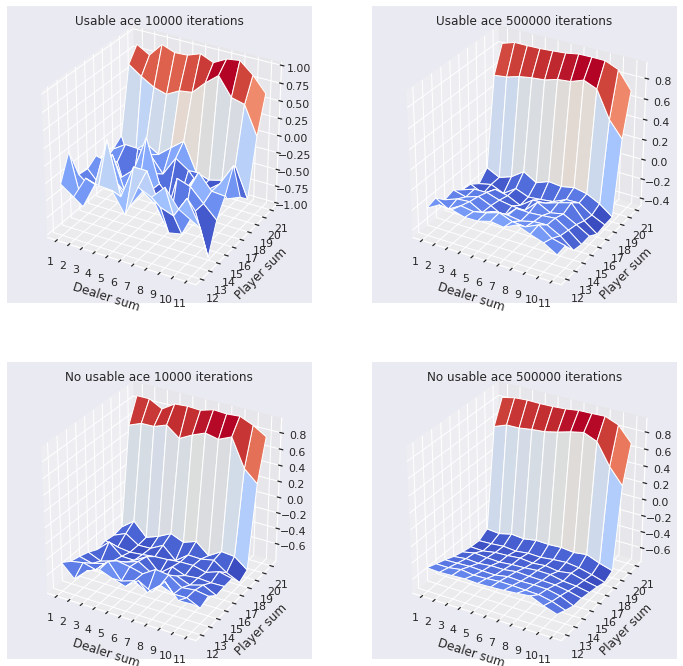

In [7]:
def figure_5_1(figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    env = BlackJack()
    policy = lambda state: state[0] < 20
    for i, iter in enumerate([10000, 500000]):
        mc = MonteCarloSVPredictor(env)
        mc.predict(policy, n=iter)
        plot_state_value(mc.state_value[:,1,:], fig.add_subplot(2,2,1+i,projection='3d'), f'Usable ace {iter} iterations')
        plot_state_value(mc.state_value[:,0,:], fig.add_subplot(2,2,3+i,projection='3d'), f'No usable ace {iter} iterations')
    
figure_5_1()

In [8]:
class MonteCarloController():
    """Monte Carlo State Action Value Controller"""
    def __init__(self, env):
        self.env = env
        self._obs_space = env.observation_spec()
        self._act_space = env.action_spec()
        self._n_actions = (np.array(self._act_space.maximum) - np.array(self._act_space.minimum) + 1).sum()
        self.create_value_function()

    def create_value_function(self):
        assert len(self._obs_space.shape) == 1, 'Observation space must be 1 dimensional'
        get_shape = lambda x: [_max - _min + 1 for _max, _min in zip(x.maximum, x.minimum)]
        shape = get_shape(self._obs_space) + get_shape(self._act_space)
        self.state_action_value = np.zeros(shape=shape, dtype=np.float32)

    def _state_to_index(self, state):
        return tuple(state[i] - self._obs_space.minimum[i] for i in range(len(state)))

    def _state_action_to_index(self, state, action):
        return tuple(state[i] - self._obs_space.minimum[i] for i in range(len(state))) + (action, )

    def generate_episode(self, policy, state=None):
        if state is not None:
            self.env.state = state
        else:
            self.env.reset()
            state = self.env.state
        finished = False
        reward = 0
        trajectory = Trajectory()
        while not finished:
            action_prob = policy[self._state_to_index(state)]
            action = np.random.choice(np.arange(self._act_space.minimum[0], self._act_space.maximum[0] + 1), p=action_prob)
            trajectory.add_step(finished, state, action, reward)
            finished, reward, new_state = self.env.step(action)
            state = new_state
        trajectory.add_step(finished, state, None, reward)
        return trajectory

    @staticmethod
    def generate_soft_policy(greedy_policy: np.ndarray, epsilon: float, n_actions: int):
        soft_policy_base = np.ones(greedy_policy.shape + (n_actions,), dtype=np.float32) * epsilon / n_actions
        with np.nditer(
            [greedy_policy],
            flags=['multi_index'],
            op_flags=[['readonly']]) as it:
            while not it.finished:
                soft_policy_base[it.multi_index + (int(it[0]), )] += 1. - epsilon
                it.iternext()
        return soft_policy_base

    def on_policy_improvement(self, policy, iters=1, epsilon=0.3, state=None, improve_policy=True, use_tqdm=False):
        n = np.zeros_like(self.state_action_value, dtype=np.int32)
        for _ in tqdm(range(iters), disable=use_tqdm):
            trajectory = self.generate_episode(policy, state=state)
            g = 0
            for i in range(len(trajectory)-1, 0, -1):
                g += trajectory[i].reward
                previous_states = set(x.state + (x.action, ) for x in trajectory[0:i-1])
                if trajectory[i-1].state + (trajectory[i-1].action, ) not in previous_states:
                    index = self._state_action_to_index(trajectory[i-1].state, trajectory[i-1].action)
                    n[index] += 1
                    self.state_action_value[index] += (g - self.state_action_value[index]) / n[index]
                    if improve_policy:
                        policy[index[:-1]] = self.generate_soft_policy(self.state_action_value[index[:-1]].argmax(-1), epsilon=epsilon, n_actions=self._n_actions)
    
    def off_policy_improvement(self, target_policy, policy=None, iters=1, epsilon=0.3, state=None, improve_policy=True, weighted=True, use_tqdm=False):
        c = np.zeros_like(self.state_action_value, dtype=np.int32)
        if policy is None:
            policy = self.generate_soft_policy(target_policy, epsilon=epsilon, n_actions=self._n_actions)
        for _ in tqdm(range(iters), disable=use_tqdm):
            trajectory = self.generate_episode(policy, state=state)
            g = 0
            w = 1
            for i in range(len(trajectory)-1, 0, -1):
                g += trajectory[i].reward
                index = self._state_action_to_index(trajectory[i-1].state, trajectory[i-1].action)
                c[index] += w
                self.state_action_value[index] += (g - self.state_action_value[index]) * (w / c[index])
                if improve_policy:
                    target_policy[index[:-1]] =  self.state_action_value[index[:-1]].argmax(-1)
                if target_policy[index[:-1]] !=  trajectory[i-1].action:
                    break
                w /= policy[index]
            if improve_policy:
                policy = self.generate_soft_policy(target_policy, epsilon=epsilon)

    @property
    def greedy_policy(self):
        return self.state_action_value.argmax(-1)

    @property
    def state_value(self):
        return self.state_action_value.max(-1)

    def get_policy_value(self, greedy_policy):
        value = np.zeros_like(greedy_policy, np.float32)
        with np.nditer(
            [value, greedy_policy],
            flags=['multi_index'],
            op_flags=[['writeonly'], ['readonly']]) as it:
            while not it.finished:
                it[0][...] = self.state_action_value[it.multi_index + (int(it[1]),)]
                it.iternext()
        return value


In [9]:
from matplotlib.colors import ListedColormap

def plot_policy(policy, ax=None, title='Policy', figsize=(6,6)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax = fig.add_subplot(111)
    x_range = policy.shape[1]
    y_range = policy.shape[0]
    cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=2)

    sns.heatmap(policy, cmap=ListedColormap(cmap), center=0.5, ax=ax)
    ax.set_xticks(np.arange(x_range) + 0.5)
    ax.set_yticks(np.arange(y_range) + 0.5)
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xticklabels([x + 1 for x in range(x_range)]);
    ax.set_yticklabels(np.arange(y_range) + 12);
    # Set the colorbar labels
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])

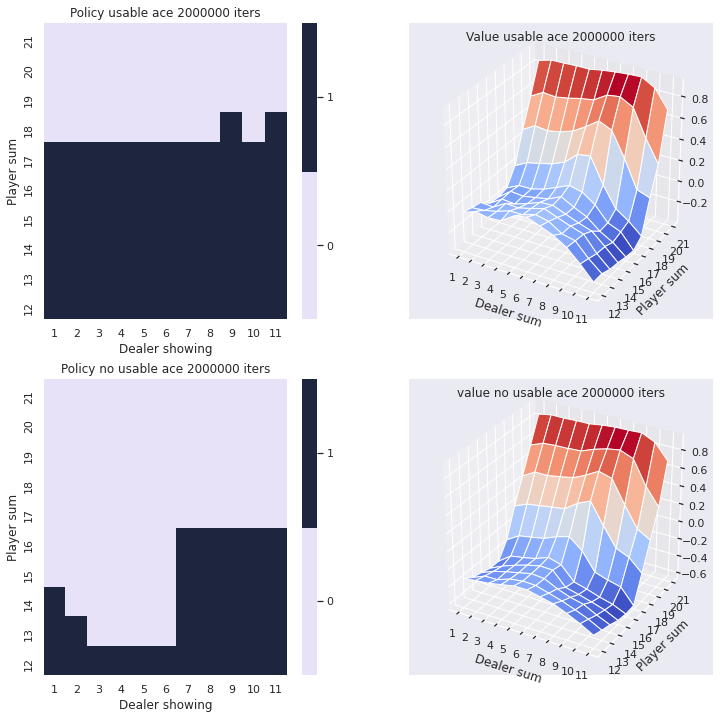

In [10]:
def figure_5_2(figsize=(12,12)):

    env = BlackJack()
    mc = MonteCarloController(env)
    
    eps = 0.3
    iterations = 2000000

    policy = mc.generate_soft_policy(mc.greedy_policy, eps, 2)
    mc.on_policy_improvement(policy, iters=iterations)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(222, projection='3d')
    plot_state_value(mc.state_value[:,1,:], ax=ax, title=f'Value usable ace {iterations} iters')
    ax = fig.add_subplot(224, projection='3d')
    plot_state_value(mc.state_value[:,0,:], ax=ax, title=f'value no usable ace {iterations} iters')

    ax = fig.add_subplot(221)
    plot_policy(mc.greedy_policy[:,1,:], ax=ax, title=f'Policy usable ace {iterations} iters')
    ax = fig.add_subplot(223)
    plot_policy(mc.greedy_policy[:,0,:], ax=ax, title=f'Policy no usable ace {iterations} iters')
    
figure_5_2()

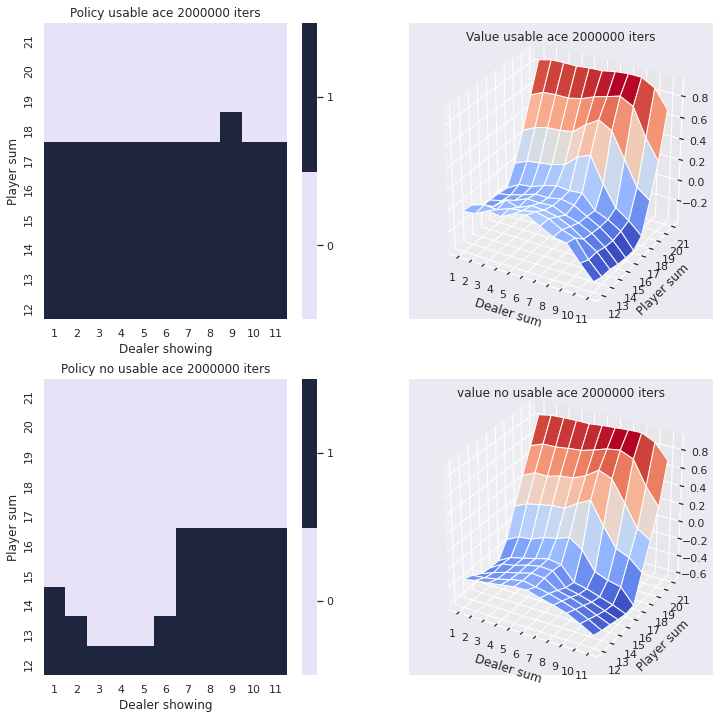

In [11]:
def figure_5_2_with_off_policy(figsize=(12,12)):

    env = BlackJack()
    mc = MonteCarloController(env)

    eps = 0.3
    iterations = 2000000

    target_policy = mc.greedy_policy
    mc.off_policy_improvement(target_policy, iters=iterations)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(222, projection='3d')
    plot_state_value(mc.state_value[:,1,:], ax=ax, title=f'Value usable ace {iterations} iters')
    ax = fig.add_subplot(224, projection='3d')
    plot_state_value(mc.state_value[:,0,:], ax=ax, title=f'value no usable ace {iterations} iters')

    ax = fig.add_subplot(221)
    plot_policy(mc.greedy_policy[:,1,:], ax=ax, title=f'Policy usable ace {iterations} iters')
    ax = fig.add_subplot(223)
    plot_policy(mc.greedy_policy[:,0,:], ax=ax, title=f'Policy no usable ace {iterations} iters')
    
figure_5_2()

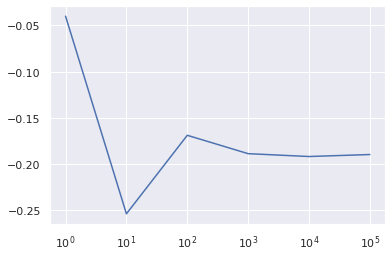

In [12]:
def figure_5_4():
    init_state = (13,1,2)
    idx_state = (1,1,1)

    target_policy = np.ones((10, 2, 11), dtype=np.int32)
    target_policy[-2:,:,:] = 0
    target_policy_prob = MonteCarloController.generate_soft_policy(target_policy, epsilon=0., n_actions=2)

    env = BlackJack()
    iterations_arr = [10**x for x in range(6)]
    runs = 50

    iter_values = np.zeros(len(iterations_arr))
    for i, iterations in tqdm(enumerate(iterations_arr)):
        runs_values = np.zeros(runs, dtype=np.float32)
        for run in tqdm(range(runs)):
            mc_off = MonteCarloController(env)
            mc_off.off_policy_improvement(target_policy, policy=target_policy_prob, iters=iterations, state=init_state, improve_policy=False, use_tqdm=False)
            runs_values[run] = mc_off.state_action_value[idx_state + (1,)]
        iter_values[i] = runs_values.mean()

    plt.plot(iterations_arr, iter_values)
    plt.xscale('log')

figure_5_4()